In [109]:
# Enhanced Comparison Analysis - Checkout Visits, Pop-up Modal, and Purchase Events
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv('analytics.csv')

In [110]:
# Examine the structure of the data
print(f"Dataset shape: {df.shape}")
print("\nColumn names:")
print(df.columns.tolist())
print("\nEvent types:")
print(df['type'].value_counts())
print("\nFirst few rows:")
df.head()

Dataset shape: (8568, 9)

Column names:
['id', 'type', 'url', 'payload', 'user_id', 'session_id', 'received_at', 'created_at', 'domain']

Event types:
type
time-spent                    7212
page-view                      748
from-directs                   213
on-onboarding                  174
from-directs-cta                42
add-to-cart                     36
uninstall                       28
open-popup                      25
checkout                        24
welcome-modal-seen              17
active                          15
enforce_wait_modal_shown        14
enforce_wait_info_expanded       7
enforce_wait_canceled            6
questionary-popup                4
open-options                     3
Name: count, dtype: int64

First few rows:


,id,type,url,payload,user_id,session_id,received_at,created_at,domain
0,19500,from-directs,www.lessextension.com/,"""anticonsumption""",less-website,27682d65-a8df-44b3-b7d0-6d77ef421460,2025-03-27T01:06:50.771229+00:00,2025-03-27T01:06:50.072+00:00,lessextension.com
1,19501,from-directs,www.lessextension.com/,"""chrome_extensions""",less-website,cb587f39-8d50-4b2e-8285-1c84c006a3f6,2025-03-27T04:40:08.182539+00:00,2025-03-27T04:40:08.386+00:00,lessextension.com
2,19502,from-directs,www.lessextension.com/,"""chrome_extensions""",less-website,cb587f39-8d50-4b2e-8285-1c84c006a3f6,2025-03-27T04:40:12.087957+00:00,2025-03-27T04:40:11.03+00:00,lessextension.com
3,19503,from-directs,www.lessextension.com/,"""shoppingaddiction""",less-website,832c9f44-45dc-41c4-b153-f52622bf8cd3,2025-03-27T06:05:28.66007+00:00,2025-03-27T06:05:28.463+00:00,lessextension.com
4,19504,from-directs,www.lessextension.com/,"""kua""",less-website,fd5b0644-a4ba-4050-b119-8b495140847b,2025-03-27T07:16:26.763114+00:00,2025-03-27T07:16:25.837+00:00,lessextension.com


# Shopping Session Analysis

We'll analyze user behavior after adding items to cart. The possible paths are:

1. Add to cart → Never proceed to checkout
2. Add to cart → Checkout → Don't place order
3. Add to cart → Checkout → See enforce_wait_modal → Wait 3 hours → Place order
4. Add to cart → Checkout → See enforce_wait_modal → Disable extension → Place order

We'll define a unique shopping session by each combination of `user_id` and `domain`.

In [111]:
# Define shopping sessions by user_id and domain

# Create a unique session ID by combining user_id and domain
df['session_id'] = df['user_id'] + '_' + df['domain']

# Count unique sessions
unique_sessions = df['session_id'].nunique()
print(f"Total unique shopping sessions: {unique_sessions}")

# Extract sessions that have at least one add-to-cart event
cart_sessions = df[df['type'] == 'add-to-cart']['session_id'].unique()
print(f"Sessions with at least one add-to-cart event: {len(cart_sessions)}")

Total unique shopping sessions: 117
Sessions with at least one add-to-cart event: 11


In [143]:
# Function to determine the path for each session
def analyze_session_paths(df):
    # Initialize dictionaries to store session paths and counts
    session_paths = {}
    path_counts = {
        'add': 0,
        'checkout': 0,
        'checkout_modal': 0,
        'checkout_modal_purchase': 0,
        'checkout_modal_uninstall': 0,
        'checkout_modal_disable': 0,
        'add_checkout': 0,
        'add_checkout_modal': 0,
        'add_checkout_modal_uninstall': 0,
        'add_checkout_modal_purchase': 0,
        'add_checkout_modal_disable': 0,
    }
    
    # Get all unique session IDs
    # Distinguish sessions by unique user_id and domain
    sessions = df[['user_id', 'domain']].drop_duplicates().apply(lambda row: f"{row['user_id']}_{row['domain']}", axis=1).values

    successful_blockings = []
    
    for session in sessions:
        # Filter data for this session
        user_id, domain = session.split('_', 1)
        session_data = df[(df['user_id'] == user_id) & (df['domain'] == domain)].sort_values('received_at')
        
        # Check for add-to-cart event
        has_add_to_cart = 'add-to-cart' in session_data['type'].values

        # Check for various events
        has_checkout = 'checkout' in session_data['type'].values
        has_modal = 'enforce_wait_modal_shown' in session_data['type'].values
        has_purchase = 'place-order' in session_data['type'].values

        deactivated = False
        uninstall = False
        
        # Check for extension deactivation after modal
        if has_modal:
            modal_time = session_data[session_data['type'] == 'enforce_wait_modal_shown']['created_at'].iloc[0]
            # Look for 'active' events where active=false after modal time
            deactivated = len(df[
                (df['user_id'] == user_id) & 
                (df['type'] == 'active') & 
                (df['created_at'] > modal_time) &
                (pd.to_datetime(df['created_at'], format="mixed") <= (pd.to_datetime(modal_time, format="mixed") + pd.Timedelta(minutes=10)))
            ]) > 0

            # Only consider uninstall events within 10 minutes after modal shown
            uninstall = len(df[
                (df['user_id'] == user_id) & 
                (df['type'] == 'uninstall') & 
                (df['created_at'] > modal_time)
                & (pd.to_datetime(df['created_at'], format="mixed") <= (pd.to_datetime(modal_time, format="mixed") + pd.Timedelta(minutes=50)))
            ]) > 0

            if has_modal and not uninstall and not deactivated:
                successful_blockings.append({user_id, session_data.iloc[0]['domain']})

        str_to_add = []

        if has_add_to_cart:
            str_to_add.append("add")
        
        if has_checkout:
            str_to_add.append("checkout")

        if has_modal:
            str_to_add.append("modal")

        if has_purchase:
            str_to_add.append("purchase")

        if deactivated:
            str_to_add.append("disable")

        if uninstall:
            str_to_add.append("uninstall")

        if len(str_to_add) == 0:
            continue

        path = "_".join(str_to_add)
        
        # Store path for this session
        session_paths[session] = path
        path_counts[path] += 1

    return session_paths, path_counts, successful_blockings

# Analyze session paths
session_paths, path_counts, successful_blockings = analyze_session_paths(df)

print("Successful blockings:")
for blocking in successful_blockings:
    print(blocking)

# Display results
for path, count in path_counts.items():
    print(f"{path}: {count} sessions")


Successful blockings:
{'amazon.com', 'e2eb1291-5fec-45e6-bded-3018f0d67d66'}
{'e2eb1291-5fec-45e6-bded-3018f0d67d66', 'etsy.com'}
add: 1 sessions
checkout: 9 sessions
checkout_modal: 1 sessions
checkout_modal_purchase: 0 sessions
checkout_modal_uninstall: 0 sessions
checkout_modal_disable: 2 sessions
add_checkout: 5 sessions
add_checkout_modal: 1 sessions
add_checkout_modal_uninstall: 3 sessions
add_checkout_modal_purchase: 0 sessions
add_checkout_modal_disable: 1 sessions


In [ ]:
# print event id = 21170 and the prior 100 events
event_id = 21170
# print event id = 21170 and the prior 100 events

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

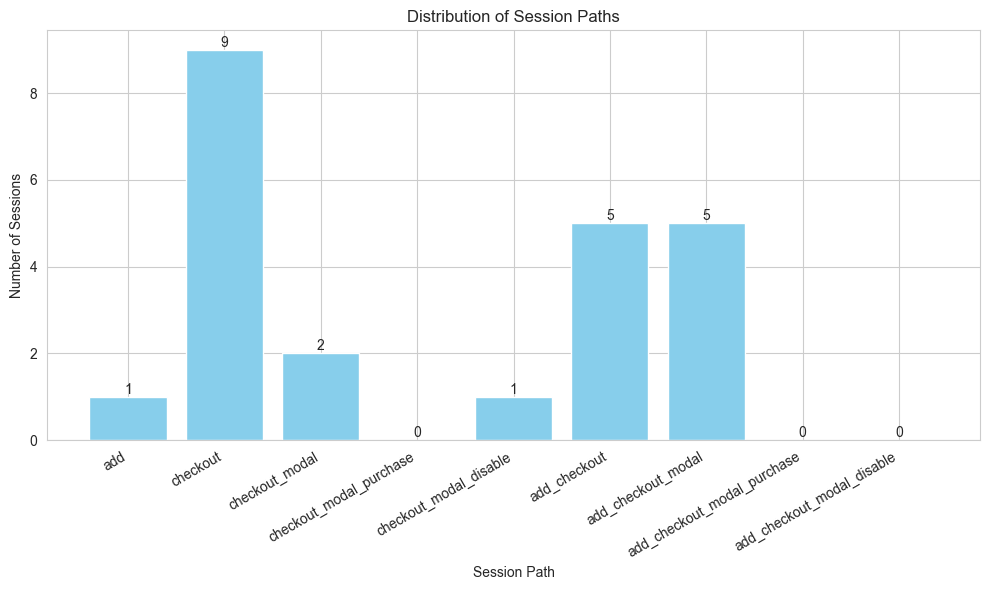

In [52]:

import matplotlib.pyplot as plt

# Prepare data for plotting
labels = list(path_counts.keys())
values = list(path_counts.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color='skyblue')

# Add value labels on top of bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(value),
                ha='center', va='bottom', fontsize=10)

plt.title('Distribution of Session Paths')
plt.xlabel('Session Path')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# Visualize the distribution of paths
plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')

# Prepare data for plotting
paths = list(path_counts.keys())
counts = list(path_counts.values())
total = sum(counts)
percentages = [count/total*100 for count in counts]

# Format labels for better readability
path_labels = {
    'add_to_cart_only': 'Add to Cart Only',
    'cart_to_checkout_only': 'Cart → Checkout (No Purchase)',
    'cart_to_checkout_to_purchase_no_modal': 'Cart → Checkout → Purchase',
    'cart_to_modal_to_wait_to_purchase': 'Cart → Modal → Wait → Purchase',
    'cart_to_modal_to_disable_to_purchase': 'Cart → Modal → Disable → Purchase',
    'other': 'Other Paths'
}

readable_paths = [path_labels[path] for path in paths]

# Create the bar plot
bar_plot = sns.barplot(x=readable_paths, y=percentages, palette='viridis')

# Add percentage labels to the bars
for i, p in enumerate(bar_plot.patches):
    bar_plot.annotate(f"{percentages[i]:.1f}%\n({counts[i]})", 
                     (p.get_x() + p.get_width()/2., p.get_height()),
                     ha='center', va='bottom')

# Customize plot
plt.title('Distribution of Shopping Cart Paths', fontsize=15)
plt.xlabel('Path Type', fontsize=12)
plt.ylabel('Percentage of Sessions', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

KeyError: 'add'

<Figure size 1200x600 with 0 Axes>

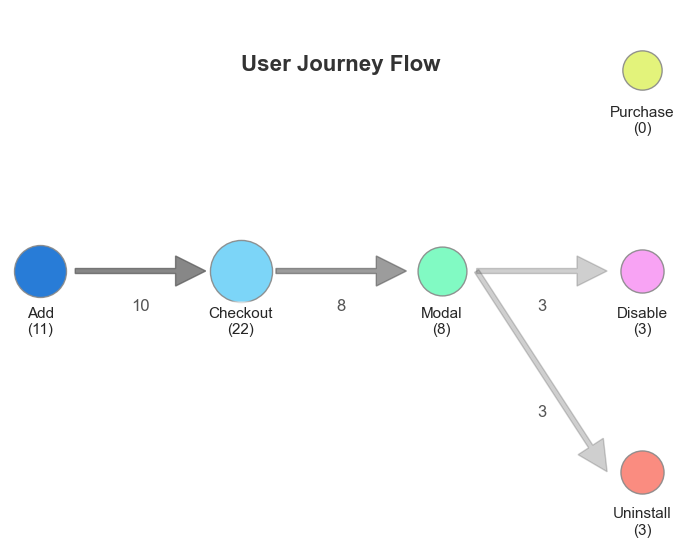

In [144]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Create a directed graph
G = nx.DiGraph()

# Define the possible states (nodes)
states = ['add', 'checkout', 'modal', 'purchase', 'disable', 'uninstall']
for state in states:
    G.add_node(state)

# Add edges based on the path counts
for path, count in path_counts.items():
    if count > 0:  # Only consider paths that have occurred
        steps = path.split('_')
        for i in range(len(steps)-1):
            # Add edge from current step to next step
            if G.has_edge(steps[i], steps[i+1]):
                # Increment weight if edge exists
                G[steps[i]][steps[i+1]]['weight'] += count
            else:
                # Create new edge with weight
                G.add_edge(steps[i], steps[i+1], weight=count)

# Calculate node sizes based on total frequency
node_counts = {node: 0 for node in states}
for path, count in path_counts.items():
    steps = path.split('_')
    for step in steps:
        if step in node_counts:
            node_counts[step] += count

colors = ['salmon', '#F899F3', '#73FABD', '#6ED1F8','#E0F26D', '#106ED3']

# Create a clean, minimal figure with white background
plt.figure(figsize=(7, 6), facecolor='white')

# Define a nice pastel color palette
pastel_colors = {
    'add': '#106ED3',      # Light periwinkle
    'checkout': '#6ED1F8',  # Light peach
    'modal': '#73FABD',    # Light lime
    'purchase': '#E0F26D',  # Light mint
    'disable': '#F899F3',   # Light salmon
    'uninstall': 'salmon'  # Light coral
}

# Define edge color (soft gray)
edge_color = '#555'

# Define node positions in a clear horizontal flow layout
positions = {
    'add': (0, 0),
    'checkout': (2, 0),
    'modal': (4, 0),
    'purchase': (6, 2),
    'disable': (6, 0),
    'uninstall': (6, -2),
}

# Normalize edge widths for better visualization
max_edge_weight = max([G[u][v]['weight'] for u, v in G.edges()])
edge_widths = [1.5 + (G[u][v]['weight'] / max_edge_weight) * 4 for u, v in G.edges()]

# Normalize node sizes
max_node_count = max(node_counts.values())
node_sizes = {node: 800 + (count / max_node_count) * 1200 for node, count in node_counts.items()}

# Draw nodes with custom colors and sizes
for node in G.nodes():
    nx.draw_networkx_nodes(
        G, positions, 
        nodelist=[node],
        node_size=node_sizes[node],
        node_color=pastel_colors[node],
        edgecolors='#888888',
        linewidths=1,
        alpha=0.9
    )

# Draw edges with slight curve, tapered edges would be ideal but requires more complex code
for u, v, data in G.edges(data=True):
    weight = data['weight']
    normalized_weight = 1.5 + (weight / max_edge_weight) * 4
    
    # Calculate edge opacity based on weight
    alpha = 0.1 + (weight / max_edge_weight) * 0.6
    
    # Draw curved arrows
    plt.arrow(
        positions[u][0] + .35, positions[u][1],           # start
        positions[v][0] - positions[u][0] - .7,          # dx
        positions[v][1] - positions[u][1],          # dy
        head_width=0.3,
        head_length=0.3,
        fc=edge_color,
        ec=edge_color,
        alpha=alpha,
        length_includes_head=True,
        width=2/40,                 # width of arrow body
    )

# Add elegant, clean labels to nodes
for node, (x, y) in positions.items():
    plt.text(
        x, y-0.5,
        f"{node.capitalize()}\n({node_counts[node]})",
        fontsize=11,
        ha='center',
        va='center',
        fontfamily='sans-serif',
        fontweight='medium',
        bbox=dict(
            boxstyle="round,pad=0.3",
            fc="white",
            ec="none",
            alpha=0.7
        )
    )

# Add edge labels using a cleaner approach
for u, v, data in G.edges(data=True):
    x1, y1 = positions[u]
    x2, y2 = positions[v]
    # Position labels slightly off the direct line
    label_pos_x = (x1 + x2) / 2
    label_pos_y = (y1 + y2) / 2 -.2
    
    # Add a small offset based on the positions
    if y1 == y2:  # horizontal edge
        offset = 0.15
    else:  # diagonal edge
        offset = 0.2
        
    if y2 > y1:  # going up
        label_pos_y += offset
    else:  # going down or flat
        label_pos_y -= offset

    plt.text(
        label_pos_x, label_pos_y,
        str(data['weight']),
        fontsize=12,
        ha='center',
        va='center',
        fontfamily='sans-serif',
        color='#555555',
        bbox=dict(
            boxstyle="round,pad=0.1",
            fc="white",
            ec="none",
            alpha=0.7
        )
    )

# Add a clean, minimal title
plt.text(
    3, 2,
    'User Journey Flow',
    fontsize=16,
    ha='center',
    fontfamily='sans-serif',
    fontweight='bold',
    color='#333333'
)

# Remove axes completely
plt.axis('off')
plt.tight_layout()

# Set equal aspect ratio to make the graph more balanced
plt.gca().set_aspect('equal', adjustable='datalim')

plt.show()

In [145]:
# Create a more detailed Sankey diagram based on actual paths
try:
    import plotly.graph_objects as go
    
    # Get all steps that have occurred in our paths
    all_steps = set()
    for path in path_counts.keys():
        if path_counts[path] > 0:
            steps = path.split('_')
            all_steps.update(steps)
    
    # Create a mapping from step names to indices for the Sankey diagram
    step_indices = {step: i for i, step in enumerate(all_steps)}
    
    # Prepare sources, targets and values for Sankey diagram
    sources = []
    targets = []
    values = []
    
    # Process each path to create the flow links
    for path, count in path_counts.items():
        if count > 0:  # Only consider paths that have occurred
            steps = path.split('_')
            for i in range(len(steps)-1):
                # Add link from current step to next step
                sources.append(step_indices[steps[i]])
                targets.append(step_indices[steps[i+1]])
                values.append(count)
    
    # Prettier node labels with capitalization
    node_labels = [step.capitalize() for step in all_steps]
    
    # Define node colors
    node_colors = [
        'rgba(31, 119, 180, 0.8)',   # Blue
        'rgba(255, 127, 14, 0.8)',    # Orange
        'rgba(44, 160, 44, 0.8)',     # Green
        'rgba(214, 39, 40, 0.8)',     # Red
        'rgba(148, 103, 189, 0.8)',   # Purple
        'rgba(140, 86, 75, 0.8)',     # Brown
        'rgba(227, 119, 194, 0.8)',   # Pink
        'rgba(188, 189, 34, 0.8)'     # Olive
    ]
    
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color='black', width=0.5),
            label=node_labels,
            color=node_colors[:len(node_labels)]
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values
        ))
    ])
    
    # Update layout
    fig.update_layout(
        title_text='User Journey Flow',
        font_size=12,
        height=600
    )
    
    fig.show()
except ImportError:
    print("Plotly is required for Sankey diagram. Install with: !pip install plotly")


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
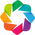

:Chord   [source,target]   (value)

In [103]:
# Create an alluvial/chord diagram using matplotlib

# Try to install holoviews and bokeh if not available
try:
    import holoviews as hv
    from holoviews import opts
    from bokeh.plotting import show
except ImportError:
    print("Installing holoviews and bokeh packages...")
    !pip install holoviews bokeh
    import holoviews as hv
    from holoviews import opts
    from bokeh.plotting import show

# Initialize HoloViews extension
hv.extension('bokeh')

# Prepare data for the chord diagram
links = []
for path, count in path_counts.items():
    if count > 0:  # Only consider paths that have occurred
        steps = path.split('_')
        for i in range(len(steps)-1):
            # Add link from current step to next step
            links.append((steps[i], steps[i+1], count))

# Convert to DataFrame
chord_data = pd.DataFrame(links, columns=['source', 'target', 'value'])

# Create the chord diagram
chord = hv.Chord(chord_data)

# Configure the appearance
chord = chord.opts(
    opts.Chord(
        cmap='Category10', edge_color='source', node_color='index',
        edge_cmap='Category10', labels='name', node_size=15,
        edge_line_width=0.5, label_text_font_size='8pt',
        title='User Flow as Chord Diagram'
    )
)

# Display the chord diagram
chord


In [104]:
# Create a sunburst chart visualization of paths
try:
    import plotly.express as px
    
    # Create a dataframe for sunburst chart
    sunburst_data = []
    
    for path, count in path_counts.items():
        if count > 0:
            steps = path.split('_')
            parent = ''
            for i, step in enumerate(steps):
                if i == 0:
                    sunburst_data.append(dict(
                        id=step,
                        parent='',
                        value=count
                    ))
                else:
                    # Create hierarchical path IDs
                    path_id = '_'.join(steps[:i+1])
                    parent_id = '_'.join(steps[:i])
                    sunburst_data.append(dict(
                        id=path_id,
                        parent=parent_id,
                        name=step,
                        value=count
                    ))
    
    # Convert to dataframe
    sunburst_df = pd.DataFrame(sunburst_data)
    
    # Create the sunburst chart
    fig = px.sunburst(
        sunburst_df, 
        ids='id',
        parents='parent',
        values='value',
        names='name',
        color_discrete_sequence=px.colors.qualitative.Dark24
    )
    
    fig.update_layout(
        title='User Journey Paths as Sunburst Chart',
        height=700,
        margin=dict(t=60, l=0, r=0, b=0)
    )
    
    fig.show()
except ImportError:
    print("Plotly is required for sunburst chart. Install with: !pip install plotly")

except Exception as e:
    print(f"Error creating sunburst chart: {e}")


In [105]:
# Visualize the distribution of paths
plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')

# Prepare data for plotting
paths = list(path_counts.keys())
counts = list(path_counts.values())
total = sum(counts)
percentages = [count/total*100 for count in counts]

# Format labels for better readability
path_labels = {
    'add_to_cart_only': 'Add to Cart Only',
    'cart_to_checkout_only': 'Cart → Checkout (No Purchase)',
    'cart_to_checkout_to_purchase_no_modal': 'Cart → Checkout → Purchase',
    'cart_to_modal_to_wait_to_purchase': 'Cart → Modal → Wait → Purchase',
    'cart_to_modal_to_disable_to_purchase': 'Cart → Modal → Disable → Purchase',
    'other': 'Other Paths'
}

readable_paths = [path_labels[path] for path in paths]

# Create the bar plot
bar_plot = sns.barplot(x=readable_paths, y=percentages, palette='viridis')

# Add percentage labels to the bars
for i, p in enumerate(bar_plot.patches):
    bar_plot.annotate(f"{percentages[i]:.1f}%\n({counts[i]})", 
                     (p.get_x() + p.get_width()/2., p.get_height()),
                     ha='center', va='bottom')

# Customize plot
plt.title('Distribution of Shopping Cart Paths', fontsize=15)
plt.xlabel('Path Type', fontsize=12)
plt.ylabel('Percentage of Sessions', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

KeyError: 'add'

<Figure size 1200x600 with 0 Axes>

In [ ]:
# Calculate key conversion metrics

# Total sessions with add-to-cart
total_cart_sessions = len(cart_sessions)

# Sessions that proceeded to checkout
checkout_sessions = path_counts['cart_to_checkout_only'] + path_counts['cart_to_checkout_to_purchase_no_modal'] + \
                    path_counts['cart_to_modal_to_wait_to_purchase'] + path_counts['cart_to_modal_to_disable_to_purchase']

# Sessions that saw the modal
modal_sessions = path_counts['cart_to_modal_to_wait_to_purchase'] + path_counts['cart_to_modal_to_disable_to_purchase']

# Sessions that completed purchase
purchase_sessions = path_counts['cart_to_checkout_to_purchase_no_modal'] + \
                   path_counts['cart_to_modal_to_wait_to_purchase'] + path_counts['cart_to_modal_to_disable_to_purchase']

# Calculate conversion rates
cart_to_checkout_rate = (checkout_sessions / total_cart_sessions) * 100 if total_cart_sessions > 0 else 0
checkout_to_purchase_rate = (purchase_sessions / checkout_sessions) * 100 if checkout_sessions > 0 else 0
modal_wait_rate = (path_counts['cart_to_modal_to_wait_to_purchase'] / modal_sessions) * 100 if modal_sessions > 0 else 0
modal_disable_rate = (path_counts['cart_to_modal_to_disable_to_purchase'] / modal_sessions) * 100 if modal_sessions > 0 else 0

# Print the results
print(f"Cart-to-Checkout Conversion: {cart_to_checkout_rate:.1f}% ({checkout_sessions} of {total_cart_sessions})")
print(f"Checkout-to-Purchase Conversion: {checkout_to_purchase_rate:.1f}% ({purchase_sessions} of {checkout_sessions})")
print(f"Modal-to-Purchase after Waiting: {modal_wait_rate:.1f}% ({path_counts['cart_to_modal_to_wait_to_purchase']} of {modal_sessions})")
print(f"Modal-to-Purchase after Disabling: {modal_disable_rate:.1f}% ({path_counts['cart_to_modal_to_disable_to_purchase']} of {modal_sessions})")

## Time Analysis

Now let's examine the time spent between key events in the shopping journey:

In [106]:
# Analyze time intervals between key events
def analyze_time_intervals(df):
    time_data = {
        'cart_to_checkout': [],
        'checkout_to_purchase': [],
        'modal_to_purchase': [],
        'modal_disable_to_purchase': []
    }
    
    for session in session_paths:
        # Skip sessions that don't match our analysis
        path = session_paths[session]
        if path == 'add_to_cart_only':
            continue
            
        # Get session data and convert timestamp to datetime
        session_df = df[df['session_id'] == session].copy()
        session_df['timestamp'] = pd.to_datetime(session_df['timestamp'], unit='ms')
        session_df = session_df.sort_values('timestamp')
        
        # Extract timestamps for events
        cart_time = session_df[session_df['type'] == 'add-to-cart']['timestamp'].min()
        
        # Calculate cart to checkout time if applicable
        if 'checkout' in session_df['type'].values:
            checkout_time = session_df[session_df['type'] == 'checkout']['timestamp'].min()
            if not pd.isna(cart_time) and not pd.isna(checkout_time):
                cart_to_checkout_mins = (checkout_time - cart_time).total_seconds() / 60
                time_data['cart_to_checkout'].append(cart_to_checkout_mins)
        
        # Calculate checkout to purchase time if applicable
        if path in ['cart_to_checkout_to_purchase_no_modal', 'cart_to_modal_to_wait_to_purchase', 'cart_to_modal_to_disable_to_purchase']:
            checkout_time = session_df[session_df['type'] == 'checkout']['timestamp'].min()
            purchase_time = session_df[session_df['type'] == 'place-order']['timestamp'].min()
            
            if not pd.isna(checkout_time) and not pd.isna(purchase_time):
                checkout_to_purchase_mins = (purchase_time - checkout_time).total_seconds() / 60
                time_data['checkout_to_purchase'].append(checkout_to_purchase_mins)
        
        # Calculate modal to purchase time (for waiting sessions)
        if path == 'cart_to_modal_to_wait_to_purchase':
            modal_time = session_df[session_df['type'] == 'enforce_wait_modal_shown']['timestamp'].min()
            purchase_time = session_df[session_df['type'] == 'place-order']['timestamp'].min()
            
            if not pd.isna(modal_time) and not pd.isna(purchase_time):
                modal_to_purchase_mins = (purchase_time - modal_time).total_seconds() / 60
                time_data['modal_to_purchase'].append(modal_to_purchase_mins)
        
        # Calculate modal to purchase time (for disable sessions)
        if path == 'cart_to_modal_to_disable_to_purchase':
            modal_time = session_df[session_df['type'] == 'enforce_wait_modal_shown']['timestamp'].min()
            purchase_time = session_df[session_df['type'] == 'place-order']['timestamp'].min()
            
            if not pd.isna(modal_time) and not pd.isna(purchase_time):
                modal_disable_to_purchase_mins = (purchase_time - modal_time).total_seconds() / 60
                time_data['modal_disable_to_purchase'].append(modal_disable_to_purchase_mins)
    
    return time_data

# Calculate time intervals
time_intervals = analyze_time_intervals(df)

# Display summary statistics for time intervals
for interval, values in time_intervals.items():
    if len(values) > 0:
        print(f"\n{interval} time (minutes):")
        print(f"  Count: {len(values)}")
        print(f"  Mean: {np.mean(values):.2f}")
        print(f"  Median: {np.median(values):.2f}")
        print(f"  Min: {min(values):.2f}")
        print(f"  Max: {max(values):.2f}")
        
        # If this is modal_to_purchase, check how many waited the full 3 hours (180 minutes)
        if interval == 'modal_to_purchase':
            waited_3_hours = sum(t >= 180 for t in values)
            print(f"  Sessions that waited at least 3 hours: {waited_3_hours} ({waited_3_hours/len(values)*100:.1f}%)")

KeyError: 'timestamp'

NameError: name 'time_intervals' is not defined

<Figure size 1400x1000 with 0 Axes>

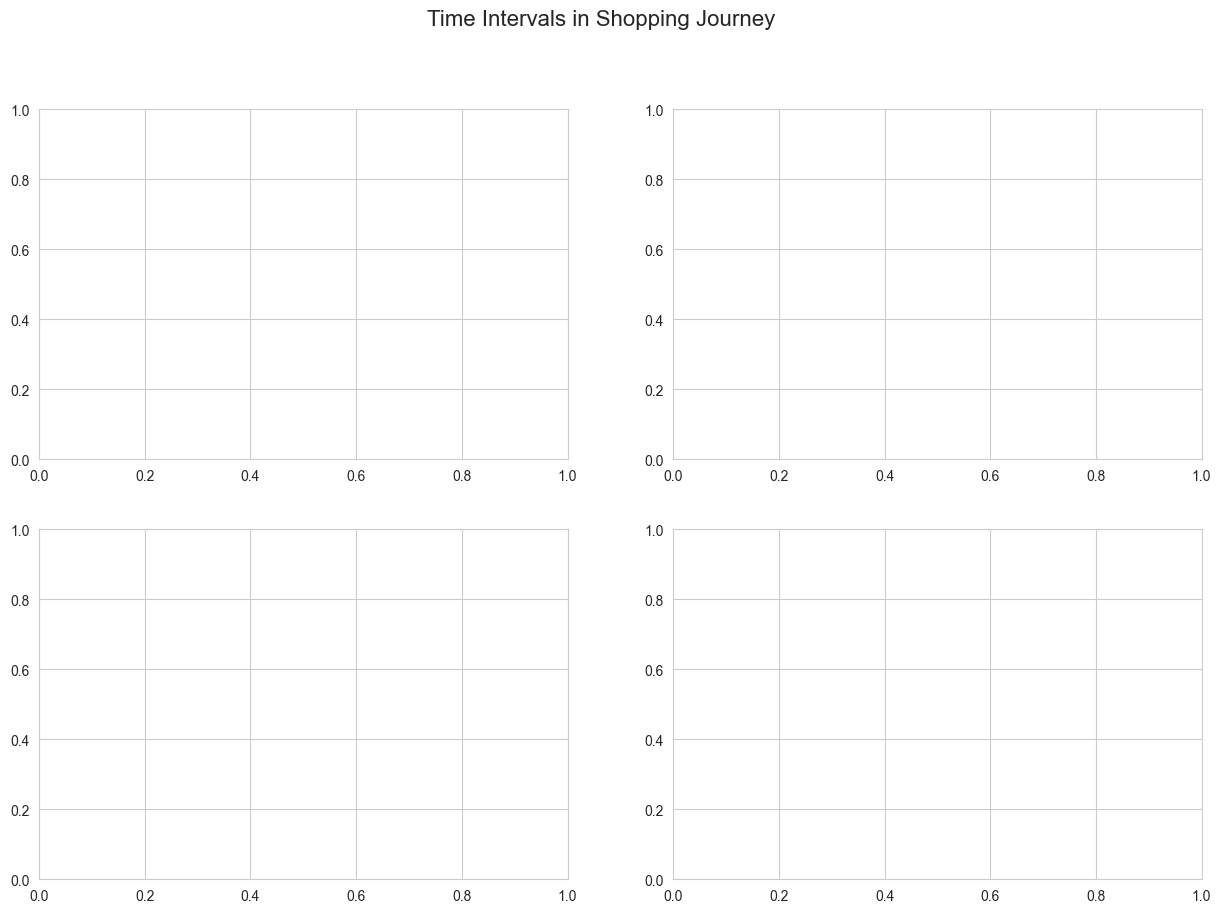

In [107]:
# Visualize time intervals
plt.figure(figsize=(14, 10))

# Create subplot grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Time Intervals in Shopping Journey', fontsize=16)

# Define labels for better readability
interval_labels = {
    'cart_to_checkout': 'Cart to Checkout',
    'checkout_to_purchase': 'Checkout to Purchase',
    'modal_to_purchase': 'Modal to Purchase (After Waiting)',
    'modal_disable_to_purchase': 'Modal to Purchase (After Disabling)'
}

# Plot histograms for each interval
for i, (interval, values) in enumerate(time_intervals.items()):
    if len(values) > 0:
        row, col = i // 2, i % 2
        ax = axes[row, col]
        
        # Skip extreme outliers for better visualization
        filtered_values = [v for v in values if v <= np.percentile(values, 95)]
        
        sns.histplot(filtered_values, kde=True, ax=ax)
        ax.set_title(interval_labels[interval], fontsize=12)
        ax.set_xlabel('Time (minutes)')
        ax.set_ylabel('Frequency')
        
        # Add mean and median lines
        mean_val = np.mean(filtered_values)
        median_val = np.median(filtered_values)
        ax.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f} min')
        ax.axvline(median_val, color='green', linestyle=':', label=f'Median: {median_val:.2f} min')
        ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Conclusion

This analysis examines different user paths after adding items to cart. Key insights include:

1. The most common path after adding to cart
2. The effectiveness of the enforce_wait_modal in deterring immediate purchases
3. The percentage of users who disable the extension to bypass the waiting period
4. Typical waiting times for users who complete a purchase after seeing the modal

These insights can help understand how effective the waiting period is at reducing impulsive purchases while not completely blocking legitimate purchase intent.

In [108]:
# Create a Sankey diagram to visualize the user flow
try:
    import plotly.graph_objects as go
    
    # Define the nodes
    labels = [
        'Add to Cart', 'Checkout', 'Modal Shown', 'Wait 3 Hours', 
        'Disable Extension', 'Purchase', 'No Further Action'
    ]
    
    # Define flow values based on our path counts
    # Source nodes (index from labels list)
    source = [0, 0, 1, 1, 2, 2, 3, 4]  
    # Target nodes (index from labels list)
    target = [1, 6, 2, 6, 3, 4, 5, 5]  
    
    # Values (number of sessions for each flow)
    # Add to Cart -> Checkout
    value_cart_to_checkout = checkout_sessions
    # Add to Cart -> No Further Action
    value_cart_to_no_action = path_counts['add_to_cart_only']
    # Checkout -> Modal
    value_checkout_to_modal = modal_sessions
    # Checkout -> No Further Action
    value_checkout_to_no_action = path_counts['cart_to_checkout_only']
    # Modal -> Wait
    value_modal_to_wait = path_counts['cart_to_modal_to_wait_to_purchase']
    # Modal -> Disable
    value_modal_to_disable = path_counts['cart_to_modal_to_disable_to_purchase']
    # Wait -> Purchase
    value_wait_to_purchase = path_counts['cart_to_modal_to_wait_to_purchase']
    # Disable -> Purchase
    value_disable_to_purchase = path_counts['cart_to_modal_to_disable_to_purchase']
    
    value = [value_cart_to_checkout, value_cart_to_no_action, value_checkout_to_modal, 
             value_checkout_to_no_action, value_modal_to_wait, value_modal_to_disable,
             value_wait_to_purchase, value_disable_to_purchase]
    
    # Define node colors
    node_colors = [
        'rgba(31, 119, 180, 0.8)',  # Add to Cart - blue
        'rgba(255, 127, 14, 0.8)',   # Checkout - orange
        'rgba(44, 160, 44, 0.8)',    # Modal Shown - green
        'rgba(214, 39, 40, 0.8)',    # Wait 3 Hours - red
        'rgba(148, 103, 189, 0.8)',  # Disable Extension - purple
        'rgba(140, 86, 75, 0.8)',    # Purchase - brown
        'rgba(188, 189, 34, 0.8)'    # No Further Action - olive
    ]
    
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node = dict(
            pad = 15,
            thickness = 20,
            line = dict(color = "black", width = 0.5),
            label = labels,
            color = node_colors
        ),
        link = dict(
            source = source,
            target = target,
            value = value
        ))
    ])
    
    # Update layout
    fig.update_layout(
        title_text="User Flow From Cart Addition to Purchase",
        font_size=12,
        height=600
    )
    
    fig.show()
except ImportError:
    print("Plotly is required for Sankey diagram. Install with: !pip install plotly")

NameError: name 'checkout_sessions' is not defined